<a href="https://colab.research.google.com/github/Zuhair0000/tensorflow_bootcamp/blob/main/04_transfer_learning_in_tensorflow_part_1_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

In [2]:
!nvidia-smi

Wed Feb 11 06:01:24 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   75C    P8             18W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

with zipfile.ZipFile('10_food_classes_10_percent.zip', 'r') as zip_ref:
  zip_ref.extractall('.')
  print("Unzipping complete")

--2026-02-11 06:01:25--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.118.207, 74.125.24.207, 172.217.194.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.118.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M  22.5MB/s    in 8.1s    

2026-02-11 06:01:34 (19.8 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]

Unzipping complete


In [4]:
import os

for dirpath, dirnames, filenames in os.walk("/content/10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'. ")

There are 2 directories and 0 images in '/content/10_food_classes_10_percent'. 
There are 10 directories and 0 images in '/content/10_food_classes_10_percent/train'. 
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/ice_cream'. 
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/fried_rice'. 
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/steak'. 
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/pizza'. 
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/chicken_wings'. 
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/chicken_curry'. 
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/ramen'. 
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/hamburger'. 
There are 0 directories and 75 images in '/content/10_food_c

In [5]:
train_dir = '/content/10_food_classes_10_percent/train'
test_dir = '/content/10_food_classes_10_percent/test'

In [6]:
import tensorflow as tf

train_data = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                         image_size=(224, 224),
                                                         batch_size=32,
                                                         seed=42)

test_data = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                         image_size=(224, 224),
                                                         batch_size=32,
                                                         seed=42)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


# Callbacks

### Tensorboard callback

This is the most powerful visualization tool in TensorFlow. Instead of staring at text output in your terminal, TensorBoard creates an interactive website running on your local machine where you can see graphs of your loss and accuracy live.

Why use it?

* Compare different experiments (e.g., "Model A with 3 layers" vs "Model B with 5 layers").

* Check if your model is overfitting (by comparing train vs validation lines).

* Visualize the model architecture graph.

In [7]:
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + '/' + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to : {log_dir}")
  return tensorboard_callback

# Craeting models using Tensorflow Hub

in the past we have used tensorflow to buidl our models layer by layer from scratch
now we are going to do a similar process, but the majority of the model's layers are going to come from tensorflow hub


In [8]:
resnet_url = 'https://www.kaggle.com/models/tensorflow/resnet-50/TensorFlow2/feature-vector/1'

efficientnet_url = 'https://www.kaggle.com/models/tensorflow/efficientnet/TensorFlow2/b0-feature-vector/1'

In [9]:
import tensorflow as tf
import tensorflow_hub as hub

In [27]:
def create_model(model_url, num_classes=10):

  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name='feature_extractor_layer')

  model = tf.keras.Sequential([
      tf.keras.layers.Input(shape=(224, 224, 3)),

      tf.keras.layers.RandomFlip("horizontal"),
      tf.keras.layers.RandomRotation(0.2),
      tf.keras.layers.RandomZoom(0.2),
      tf.keras.layers.RandomHeight(0.2),
      tf.keras.layers.RandomWidth(0.2),

      tf.keras.layers.Rescaling(1/255.),

      feature_extractor_layer,

      tf.keras.layers.Dense(num_classes, activation='softmax', name="output_layer")
  ])

  return model

In [28]:
resnet_model = create_model(resnet_url,
                            num_classes=10)

In [29]:
resnet_model.compile(loss='sparse_categorical_crossentropy',
                     optimizer='Adam',
                     metrics=['accuracy'])

In [30]:
resnet_history = resnet_model.fit(train_data,
                 epochs=5,
                 steps_per_epoch = len(train_data),
                 validation_data=test_data,
                 validation_steps=len(test_data),
                 callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub', experiment_name='resnet50v2')])

Saving TensorBoard log files to : tensorflow_hub/resnet50v2/20260211-061942
Epoch 1/5
24/24 [==============================] - 51s 2s/step - loss: 2.0516 - accuracy: 0.3040 - val_loss: 1.2112 - val_accuracy: 0.6068
Epoch 2/5
24/24 [==============================] - 32s 1s/step - loss: 1.2230 - accuracy: 0.6067 - val_loss: 0.8544 - val_accuracy: 0.7220
Epoch 3/5
24/24 [==============================] - 32s 1s/step - loss: 0.9088 - accuracy: 0.7227 - val_loss: 0.6999 - val_accuracy: 0.7780
Epoch 4/5
24/24 [==============================] - 32s 1s/step - loss: 0.7830 - accuracy: 0.7813 - val_loss: 0.6390 - val_accuracy: 0.7956
Epoch 5/5
24/24 [==============================] - 27s 1s/step - loss: 0.6950 - accuracy: 0.7893 - val_loss: 0.5865 - val_accuracy: 0.8044


In [31]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  plt.plot(epochs, loss, label="training loss")
  plt.plot(epochs, val_loss, label="val loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label="training accuracy")
  plt.plot(epochs, val_accuracy, label="val accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

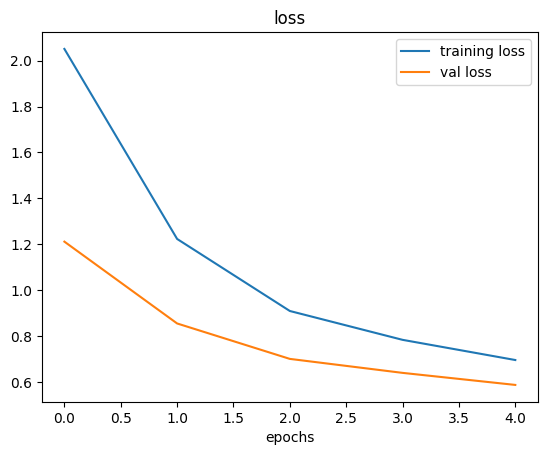

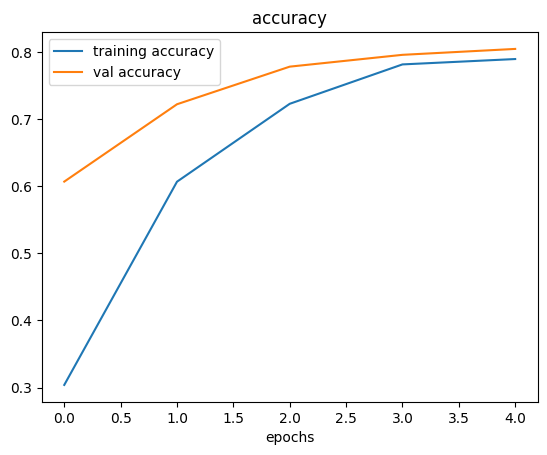

In [32]:
plot_loss_curves(resnet_history)

In [33]:
efficientnet_model = create_model(efficientnet_url)

In [34]:
efficientnet_model.compile(loss = 'sparse_categorical_crossentropy',
                           optimizer='Adam',
                           metrics=['accuracy'])

In [35]:
efficientnet_history = efficientnet_model.fit(train_data,
                                              steps_per_epoch=len(train_data),
                                              validation_data = test_data,
                                              validation_steps=len(test_data),
                                              epochs=5,
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", experiment_name="efficientnet")])

Saving TensorBoard log files to : tensorflow_hub/efficientnet/20260211-062830
Epoch 1/5
24/24 [==============================] - 30s 805ms/step - loss: 2.0253 - accuracy: 0.3080 - val_loss: 1.4713 - val_accuracy: 0.6664
Epoch 2/5
24/24 [==============================] - 14s 577ms/step - loss: 1.3863 - accuracy: 0.6707 - val_loss: 1.0367 - val_accuracy: 0.7572
Epoch 3/5
24/24 [==============================] - 14s 572ms/step - loss: 1.0729 - accuracy: 0.7480 - val_loss: 0.8279 - val_accuracy: 0.7964
Epoch 4/5
24/24 [==============================] - 15s 584ms/step - loss: 0.9064 - accuracy: 0.7733 - val_loss: 0.7154 - val_accuracy: 0.8176
Epoch 5/5
24/24 [==============================] - 12s 496ms/step - loss: 0.8118 - accuracy: 0.7907 - val_loss: 0.6407 - val_accuracy: 0.8308


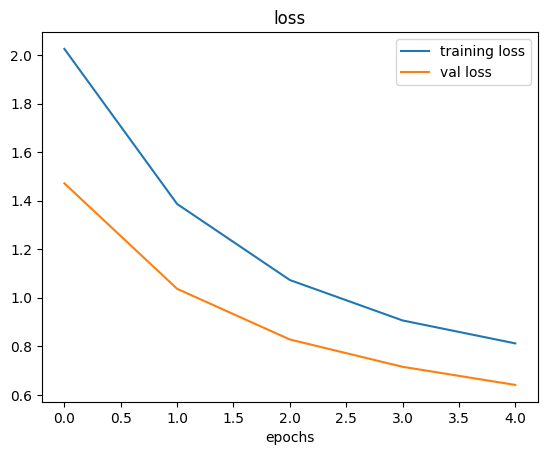

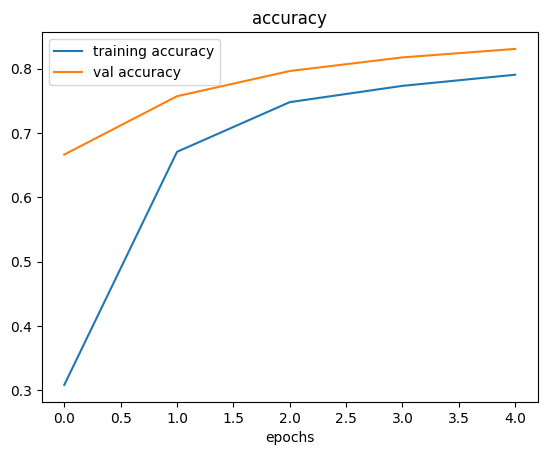

In [36]:
plot_loss_curves(efficientnet_history)